# Embeddings Neuronales


**TODO**

### Importanción de librería requeridas

In [1]:
import gensim.corpora as corpora
from gensim.models import Word2Vec, FastText

from collections import Counter
import numpy as np

import pickle
import pandas as pd

from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_samples, silhouette_score

import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)

%matplotlib inline


### Definición de variables globales

In [2]:
TEXT_FILE_READ = 'docs/preprocessing_reddit_data.csv'
TEXT_SAVE_FILE = 'docs/reddit_data_fasttext.csv'
FILENAME_PICKLE = "docs/tmpreddit.pickle"
n_clusters = 120

### Lectura de los comentarios de Reddit

Los comentarios fueron previamente preprocesados (Ver en TODO).

In [3]:
with open(FILENAME_PICKLE, 'rb') as f:
    df = pickle.load(f)


### Vocabulario

In [4]:
# Create Dictionary
id2word = corpora.Dictionary(df['lemma_tokens'])

# Filtering Extremes
id2word.filter_extremes(no_below=2, no_above=.99)

# Creating a corpus object
corpus = [id2word.doc2bow(d) for d in df['lemma_tokens']]


In [5]:
processed_corpus = df['lemma_tokens']


### Entrenamiento del modelo Word2Vec

In [6]:
model = FastText(sentences=processed_corpus, vector_size=100, window=5, min_count=1, workers=4)
model.train(processed_corpus, total_examples=len(processed_corpus), epochs=100)
model.save("word2vec.model")

In [7]:
word_vecs = []
vocabulary = list(model.wv.key_to_index)

for key in model.wv.key_to_index:
    word_vecs.append(model.wv[key])

In [8]:
# algunas predicciones

model.wv.most_similar("cristina")

[('gnula', 0.8394178748130798),
 ('pwlicula', 0.8072469234466553),
 ('nula', 0.8004575371742249),
 ('cápsula', 0.7768926620483398),
 ('célula', 0.7684698104858398),
 ('lula', 0.7421151399612427),
 ('molecula', 0.7387095093727112),
 ('mayuscula', 0.7321993112564087),
 ('mula', 0.7279105186462402),
 ('cédula', 0.7251480221748352)]

### Generación de vectores desde documentos

In [9]:
def vectorize(list_of_docs, model):
    """Generate vectors for list of documents using a Word Embedding

    Args:
        list_of_docs: List of documents
        model: Gensim's Word Embedding

    Returns:
        List of document vectors
    """
    features = []

    for tokens in list_of_docs:
        zero_vector = np.zeros(model.vector_size)
        vectors = []
        for token in tokens:
            if token in model.wv:
                try:
                    vectors.append(model.wv[token])
                except KeyError:
                    continue
        if vectors:
            vectors = np.asarray(vectors)
            avg_vec = vectors.mean(axis=0)
            features.append(avg_vec)
        else:
            features.append(zero_vector)
    return features
    
vectorized_docs = vectorize(processed_corpus, model=model)
len(vectorized_docs), len(vectorized_docs[0])



(27791, 100)

### Generación de clusters

In [10]:
def mbkmeans_clusters(
	X, 
    k, 
    mb, 
    print_silhouette_values, 
):
    """Generate clusters and print Silhouette metrics using MBKmeans

    Args:
        X: Matrix of features.
        k: Number of clusters.
        mb: Size of mini-batches.
        print_silhouette_values: Print silhouette values per cluster.

    Returns:
        Trained clustering model and labels based on X.
    """
    km = KMeans(n_clusters=k).fit(X)
    print(f"For n_clusters = {k}")
    print(f"Silhouette coefficient: {silhouette_score(X, km.labels_):0.2f}")
    print(f"Inertia:{km.inertia_}")

    if print_silhouette_values:
        sample_silhouette_values = silhouette_samples(X, km.labels_)
        print(f"Silhouette values:")
        silhouette_values = []
        for i in range(k):
            cluster_silhouette_values = sample_silhouette_values[km.labels_ == i]
            silhouette_values.append(
                (
                    i,
                    cluster_silhouette_values.shape[0],
                    cluster_silhouette_values.mean(),
                    cluster_silhouette_values.min(),
                    cluster_silhouette_values.max(),
                )
            )
        silhouette_values = sorted(
            silhouette_values, key=lambda tup: tup[2], reverse=True
        )
        for s in silhouette_values:
            print(
                f"    Cluster {s[0]}: Size:{s[1]} | Avg:{s[2]:.2f} | Min:{s[3]:.2f} | Max: {s[4]:.2f}"
            )
    return km, km.labels_

Text(0.5, 1.0, 'Elbow curve')

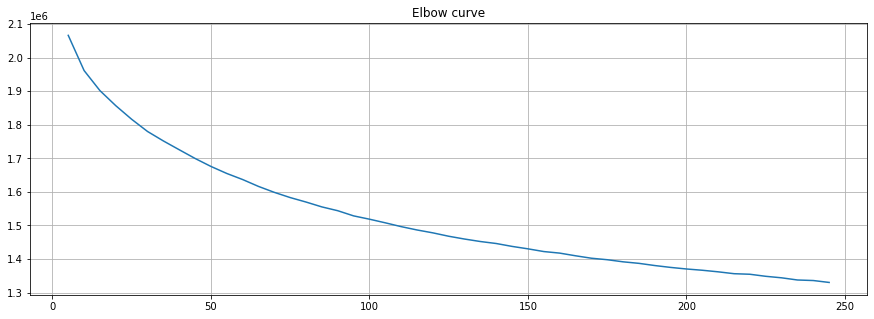

In [11]:
from sklearn.cluster import KMeans
from matplotlib import pyplot as plt

min = 5
max = 250
step = 5

distorsions = []
for k in range(min, max, step):
    kmeans = KMeans(n_clusters=k)
    kmeans.fit(vectorized_docs)
    distorsions.append(kmeans.inertia_)

fig = plt.figure(figsize=(15, 5))
plt.plot(range(min, max, step), distorsions)
plt.grid(True)
plt.title('Elbow curve')


In [12]:
clustering, cluster_labels = mbkmeans_clusters(
	X=vectorized_docs,
    k=n_clusters,
    mb=500,
    print_silhouette_values=True,
)
df_clusters = pd.DataFrame({
    "text": df["body"].values,
    "tokens": [" ".join(text) for text in processed_corpus],
    "cluster": cluster_labels
})



For n_clusters = 120
Silhouette coefficient: 0.02
Inertia:1477145.2333762373
Silhouette values:
    Cluster 13: Size:242 | Avg:0.23 | Min:0.04 | Max: 0.38
    Cluster 20: Size:56 | Avg:0.19 | Min:-0.01 | Max: 0.38
    Cluster 71: Size:20 | Avg:0.16 | Min:-0.04 | Max: 0.29
    Cluster 84: Size:19 | Avg:0.12 | Min:-0.07 | Max: 0.36
    Cluster 54: Size:154 | Avg:0.11 | Min:-0.08 | Max: 0.29
    Cluster 119: Size:86 | Avg:0.10 | Min:-0.06 | Max: 0.30
    Cluster 107: Size:164 | Avg:0.09 | Min:-0.07 | Max: 0.30
    Cluster 73: Size:314 | Avg:0.08 | Min:-0.03 | Max: 0.21
    Cluster 32: Size:155 | Avg:0.08 | Min:-0.09 | Max: 0.26
    Cluster 18: Size:296 | Avg:0.08 | Min:-0.05 | Max: 0.19
    Cluster 56: Size:226 | Avg:0.07 | Min:-0.10 | Max: 0.24
    Cluster 26: Size:68 | Avg:0.07 | Min:-0.05 | Max: 0.28
    Cluster 25: Size:848 | Avg:0.07 | Min:-0.01 | Max: 0.15
    Cluster 10: Size:23 | Avg:0.07 | Min:-0.07 | Max: 0.24
    Cluster 69: Size:161 | Avg:0.07 | Min:-0.08 | Max: 0.27
    Clust

### *Top terms* por cluster (basado en los centroides de los clusters)

In [13]:
print("Most representative terms per cluster (based on centroids):")
for i in range(n_clusters):
    tokens_per_cluster = ""
    most_representative = model.wv.most_similar(positive=[clustering.cluster_centers_[i]], topn=5)
    for t in most_representative:
        tokens_per_cluster += f"{t[0]} "
    print(f"Cluster {i}: {tokens_per_cluster}")



Most representative terms per cluster (based on centroids):
Cluster 0: /s ^/s x200b ^(/s ̲͙̪͕͇̤̏̌̊̑͆̌m̳̦͂̓į͉̟͓̰̞͆̎͌̉̾̕l͟͡i̩̙̙̦̟̱̱͗͆̽͌͊͛͝c̨̛̳̜̹̬̺̲͎̹͙͙̻̲̞̗̹̯̿̈͛̋̄̇̓̏̍̓͑͂̇̌̒̀͢͟͠͡ờ̧̫͓͈̝̮̝̬̮̩̤͚̟̥̲̼͙̗̝̆̇́̉͛̅́̽̽̋́̓̂͆̏̒̚͟͝͞ͅṣ̨̨̛̼̩͚̘̮͉̲̝͓͖̱͓͓̎̂̽̑̎̎̃̄̔͊̑͊̂̕͜͞͞?̧̡̛̛̰̤͎̪͔̬̞̼̳̣̩͇̺̰̣͔͔͍̺̩̥̓́̈͛̍̐̇̆̂̈́̅̑̓̐͗̄̅̚̚͘͟͟͠͝͞͞ͅ~~. 
Cluster 1: \+agente exigente agente eficientemente oyente 
Cluster 2: auto arauto flauto autoretrato autobús 
Cluster 3: pintamelo pijudo piolo pichón 😇 
Cluster 4: hacer "hacer rehacer hacercir deshacer 
Cluster 5: pizzanesa arroz fritas frita bayonesa 
Cluster 6: seguiar seguros seguro seguirr seguir 
Cluster 7: ado rayado nómado naado wado 
Cluster 8: hijaeputa hijo putamadre puta hijo_puta 
Cluster 9: mes mesas mesías mesía mesopotamica 
Cluster 10: so soi soñá éso soõ 
Cluster 11: esperáramo esperándolos espertma esperabar espert-delca 
Cluster 12: lirar elvirar girar sátirar \*mirar 
Cluster 13: theory theyll thought th thank 
Cluster 14: groserio brujerio utilerio sumerio 

### *Top terms* por cluster (basado en las palabras más frecuentes)

In [14]:
for i in range(n_clusters):
    tokens_per_cluster = ""
    most_frequent = Counter(" ".join(df_clusters.query(f"cluster == {i}")["tokens"]).split()).most_common(5)
    for t in most_frequent:
        tokens_per_cluster += f"{t[0]}({str(t[1])}) "
    print(f"Cluster {i}: {tokens_per_cluster}")


Cluster 0: /s(85) x200b(84) duda(5) edit(3) gorila(3) 
Cluster 1: gente(217) pasar(27) justamente(18) realmente(18) entender(17) 
Cluster 2: auto(126) pasar(15) calle(14) moto(13) bici(13) 
Cluster 3: huevo(38) él(37) bola(28) romper(28) loco(27) 
Cluster 4: hacer(197) él(41) querer(9) falta(8) amigo(7) 
Cluster 5: carne(42) milanesa(34) fideo(25) pan(24) queso(22) 
Cluster 6: seguir(99) seguro(95) año(7) esperar(7) pasar(7) 
Cluster 7: lado(34) pelado(20) pedo(17) grado(13) cerrado(9) 
Cluster 8: hijo(42) puta(37) puto(9) madre(6) remil(4) 
Cluster 9: mes(162) venir(14) año(14) él(12) pasar(8) 
Cluster 10: so(22) vo(3) pod(2) hermano(2) ✌(2) 
Cluster 11: espert(94) esperar(82) caño(22) debate(18) respuesta(9) 
Cluster 12: tirar(103) mirar(66) llorar(10) pasar(8) entrar(8) 
Cluster 13: the(200) and(74) of(72) you(66) is(55) 
Cluster 14: serio(73) ministerio(9) comentario(8) rio(7) usuario(5) 
Cluster 15: andar(98) mandar(54) ondar(15) querer(7) pasar(7) 
Cluster 16: amigo(125) amiga(5)

### Recupere los documentos más representativos (basados en los centroides de los clústeres) para un cluster en particular

In [15]:
test_cluster = 22
most_representative_docs = np.argsort(
    np.linalg.norm(vectorized_docs - clustering.cluster_centers_[test_cluster], axis=1)
)
for d in most_representative_docs[:10]:
    print( df["body"].values[d])
    print("-------------")

Lo único que se, es que no hay que poner exigencias. Es un instant-red flag 🚩.. Fuente: con cada minita que salgo siempre hablo de Tinder para aprender y entender cómo funciona.
-------------
Si les dicen n3gros de M1erd4 se ofenden encima. Con una topadora por encima hay que pasarles.
-------------
Varsky entendió todo, por escándalo es el mejor en su trabajo.
-------------
Campaña de que? Tus papás son primos? Nah fuera de joda, la gente quiere cosas a precios ridículos y los que lo venden obligados hacen todo lo posible para no vender.
-------------
No entiendo. Dirías que los frenos no sirven porque en warnes te venden discos de freno totalmente gastados?
-------------
"Hecerles entender que estàn equivocados" , el general estaría orgulloso
-------------
El Nazareno. Creo q sólo los venden en Cba. Fijate si hacen envíos
-------------
Mira que interesante!! Puede ser que persiguen mucho jajajaj. En que formas lo notaste a eso?. A que te referis con que en Argentina da igual cualquie

In [16]:
#solo test
#print(len(vectorized_docs))
#print(vectorized_docs[0])

test_v = vectorize([['defender', 'peso', 'siente', 'corazón', 'compro', 'pesos', 'tasa', 'fijo', 'año']], model=model)
prediction = clustering.predict(test_v)
print(prediction)

ver = "['defender', 'peso', 'siente', 'corazón', 'compro', 'pesos', 'tasa', 'fijo', 'año']"
ver = "tapastir baño tirar balde aguo"
test_v = vectorize([ver], model=model)
prediction = clustering.predict(test_v)
print(prediction)


str2 = ver.split(" ")
print(str2)

[26]
[24]
['tapastir', 'baño', 'tirar', 'balde', 'aguo']


In [17]:
reddit = pd.read_csv(TEXT_FILE_READ)

from sklearn.metrics import pairwise_distances


def get_cluster(row):
    test_v = vectorize([str(row).split(" ")], model=model)
    #print('****************')
    #print(clustering.fit_predict(test_v, 1))
    #print(clustering.predict(test_v))
    return clustering.predict(test_v)

reddit['cluster'] = reddit.apply(lambda row: get_cluster(row['body_preprocessing']) , axis = 1) 


In [18]:
# Show
reddit.head(10)

,score,id,flair,comms_num,body,comment_parent_id,is_replay,Unnamed: 7,Unnamed: 8,Unnamed: 9,Unnamed: 10,Unnamed: 11,Unnamed: 12,Unnamed: 13,Unnamed: 14,lemma_tokens,body_preprocessing,cluster
0,1,hfw14mt,Discusion🧐,1,todo para decir que tapaste el baño. tira un b...,q44kw3,False,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,"['tapastir', 'baño', 'tirar', 'balde', 'aguo']",tapastir baño tirar balde aguo,[12]
1,1,hfw41eh,Discusion🧐,0,"sopapa primero master, si hay tapón te vas a t...",hfw14mt,True,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,"['sopapa', 'master', 'tapón', 'va', 'teñir', '...",sopapa master tapón va teñir medio,[32]
2,1,hfw1ao2,Discusion🧐,0,"Usas la sopapa, o tiras agua caliente con un b...",q44kw3,False,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,"['sopapo', 'tira', 'agua', 'caliente', 'balde']",sopapo tira agua caliente balde,[43]
3,1,hfw3jof,Discusion🧐,2,Lo que he probado que siempre me dio resultado...,q44kw3,False,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,"['probado', 'resultado', 'sellar', 'boca', 'in...",probado resultado sellar boca inodoro tirar ca...,[65]
4,1,hfw6v4i,Discusion🧐,0,Estas cobrando por dar mantenimiento y no sabe...,q44kw3,False,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,"['cobrar', 'mantenimiento', 'carajo', 'kjjjjjj...",cobrar mantenimiento carajo kjjjjjjjjj vivirio...,[59]
5,1,hfw26iv,Discusion🧐,0,"Si tenes algo con punta, metelo y hace un poco...",q44kw3,False,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,"['tén', 'punto', 'metelo', 'fuerza', 'romper',...",tén punto metelo fuerza romper tapo baño tirar...,[43]
6,1,hfw2gof,Discusion🧐,1,"Con una manguera para regar el jardín, si tene...",q44kw3,False,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,"['regar', 'jardín', 'tén', 'pod', 'probar']",regar jardín tén pod probar,[113]
7,1,hfw5s13,Discusion🧐,0,"despues regas el jardin y se lava sola, solo q...",hfw2gof,True,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,"['rega', 'jardin', 'lava', 'tenés', 'lavarte',...",rega jardin lava tenés lavarte mano pulgar chorro,[23]
8,1,hfw3air,Discusion🧐,0,La respuesta real es que se venden unos caños ...,q44kw3,False,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,"['respuesta', 'real', 'vender', 'caño', 'alamb...",respuesta real vender caño alambrado decir cañ...,[59]
9,7,hfvxa6w,Discusion🧐,3,Mi alfajor favorito es el Havana,q443eo,False,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,"['alfajor', 'favorito', 'haván']",alfajor favorito haván,[5]


In [19]:
reddit.to_csv(TEXT_SAVE_FILE, index=False)

In [20]:
for i in range(n_clusters):
    reddit[(reddit["cluster"] == i)][['flair', 'body']].to_csv('docs/testlda/' + str(i) + '.csv')


FileNotFoundError: [Errno 2] No such file or directory: 'docs/testlda/0.csv'